In [1]:
import pandas as pd

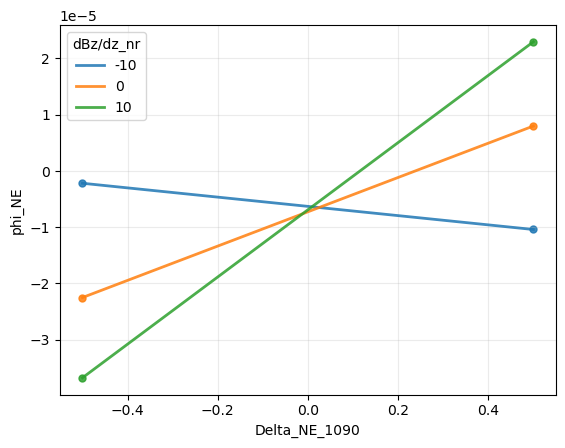

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv(r"C:\ACME_analysis\multiple_results\sequencedf_result\0016.2021.csv")
fig, ax = plt.subplots()
# ---- You set these ----
fit_against = "Delta_NE_1090"     # independent variable to fit against
group_by    = "dBz/dz_nr" # column to group by
y_name      = "phi_NE"     # dependent variable
dy_name     = "uncertainty_phi_NE"    # uncertainty in y (for weights 1/dy^2)
degree      = 1                # 1=linear, 2=quadratic, ...

# You said you'll pass these in / already have them
# fig, ax = plt.subplots()  # if you don't already have them

# ---- Data prep ----
cols = [fit_against, group_by, y_name, dy_name]
d = df[cols].copy()
d = d.dropna(subset=[fit_against, y_name, dy_name])

# keep only finite dy and dy>0 (required for weights)
d = d[np.isfinite(d[dy_name]) & (d[dy_name] > 0)]

# optional: make group labels stable/pretty
# d[group_by] = d[group_by].astype(str)

# ---- Plot: one color per group, scatter + fitted line ----
# matplotlib will automatically cycle colors each time we call plot()
for g, gdf in d.groupby(group_by, sort=True):
    x = gdf[fit_against].to_numpy(dtype=float)
    y = gdf[y_name].to_numpy(dtype=float)
    dy = gdf[dy_name].to_numpy(dtype=float)

    # need at least degree+1 points
    if x.size < (degree + 1):
        continue

    # weights = 1/dy^2 for inverse-variance weighted least squares
    w = 1.0 / (dy * dy)

    # Weighted polynomial fit: minimize sum( w * (y - p(x))^2 )
    coefs = np.polyfit(x, y, deg=degree, w=np.sqrt(w))
    p = np.poly1d(coefs)

    # plot scatter first, capture its color, then use same color for line
    sc = ax.scatter(x, y, s=25, alpha=0.85, label=None)
    color = sc.get_facecolor()[0] if len(sc.get_facecolor()) else sc.get_edgecolor()

    # line: evaluate on sorted x-range for nice line
    xs = np.linspace(np.nanmin(x), np.nanmax(x), 200)
    ax.plot(xs, p(xs), color=color, lw=2, label=f"{g}")

# ---- Cosmetics ----
ax.set_xlabel(fit_against)
ax.set_ylabel(y_name)
ax.legend(title=group_by, frameon=True)
ax.grid(True, alpha=0.25)

# If you're in a notebook and want to show it explicitly:
# plt.show()
